In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin
import numpy as np
import itertools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/zhoutong/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 读取数据部分

In [2]:
global_path = "/home/zhoutong/data/apus_ad/data_2018-09-03_to_2018-09-09/data_2018-09-03_to_2018-09-09_train_shuffled"
f=open(global_path,"r")
line = f.readline()
info = line.strip("[]\n").split("\t")

In [3]:
global_path = "/home/zhoutong/data/apus_ad/data_2018-09-03_to_2018-09-09/data_2018-09-03_to_2018-09-09_train_shuffled"
global_max_numeric = [999, 10001,13]
## 为测试xgb构造字符串libsvm的输入
def _yield_xgb_libsvm(reader_path):
    with open(reader_path, "r") as f:
        for line in f:
            info = line.strip("[]\n").split("\t")
            tmp = " ".join(info[:3]).split(" ")
            info_str = " ".join([tmp[0]] + sorted(tmp[1:], key=lambda x : int(x.split(":")[0])))
            yield info_str
def get_xgb_generator():
    return _yield_xgb_libsvm(global_path)


## DeepFM使用的输入
def _yield_apus_ad_generator(reader_path,max_numeric):
        with open(reader_path, "r") as f:
            for line in f:
                info = line.strip("[]\n").split("\t")
                label = int(info[0])
                numeric_f = info[1].split(" ")
                category_f = info[2].split(" ")
                multi_hot_f_app = info[3].split(" ")
                multi_hot_f_tag = info[4].split(" ")
                y = [label]
                def get_idx_and_value(feature_info):
                    idx = [int(x.split(":")[0]) for x in feature_info]
                    value = [float(x.split(":")[1]) for x in feature_info]
                    return idx,value
                Xi_numeric, Xv_numeric = get_idx_and_value(numeric_f)
                Xi_category, Xv_category = get_idx_and_value(category_f)
                Xi_multi_hot_app, Xv_multi_hot_app = get_idx_and_value(multi_hot_f_app)
                Xi_multi_hot_tag, Xv_multi_hot_tag = get_idx_and_value(multi_hot_f_tag)
                if sorted(zip(Xi_numeric, Xv_numeric),key=lambda x: x[0])[1][1]==0:
                    pass
                # Xv_numeric 归一化
                if len(max_numeric)>0:
                    # 根据索引是0还是1还是2从 max_nuemeric里面取值
                    Xv_numeric = []
                    for i in numeric_f:
                        idx = int(i.split(":")[0])
                        v = float(i.split(":")[1])
                        Xv_numeric.append(v/max_numeric[idx])
                    Xv_numeric = list(map(lambda x: x if x<=1 else 1, Xv_numeric))
                yield [y, Xi_numeric, Xv_numeric, Xi_category, Xv_category, Xi_multi_hot_app, Xv_multi_hot_app,Xi_multi_hot_tag,Xv_multi_hot_tag]
def get_generator(max_numeric_):
    return _yield_apus_ad_generator(global_path,max_numeric_)

data_gen = get_generator(global_max_numeric)
xgb_data_gen=get_xgb_generator()

In [4]:
feature_map_dict = {}
with open("/home/zhoutong/data/apus_ad/data_2018-08-20_to_2018-09-09_sampled/feature_map_2018-08-20_to_2018-09-02","r") as f:
    feature_map = f.readlines()
    feature_map = map(lambda x: x.split("\t") ,feature_map)
    for f_name,f_idx in feature_map:
        feature_map_dict[int(f_idx)] = f_name

len(feature_map_dict)

189052

In [28]:
data = list(itertools.islice(xgb_data_gen,0,50))
y_ , feature_ = [], []
for i in data:
    label = i.split(" ")[0]
    feat = i.split(" ")[1:]
    feature = []
    for j in feat:
        feat_name = feature_map_dict[int(j.split(":")[0])]
        feat_value = float(j.split(":")[1])
        feature.append([feat_name, feat_value])
    feature_.append(feature)
    y_.append(label)

# y_
np.array(feature_).shape









(50, 28, 2)

## 数据分析
<br/>

- ### 检查异常数据的条数（广告底价为0认为是异常数据）

In [109]:
%%time
cnt = 0
while True:
    try:
        idx,v = next(data_gen)[1:3]
        if sorted(zip(idx, v),key=lambda x: x[0])[1][1]==0:
            cnt += 1
    except StopIteration:
        break
print(cnt)

0
CPU times: user 13min 36s, sys: 2.29 s, total: 13min 38s
Wall time: 13min 37s


In [7]:
data_gen_no_normalize = get_generator([])
template_data = list(itertools.islice(data_gen_no_normalize,0,1024*10))
xgb_template_data = list(itertools.islice(xgb_data_gen,0,1024*10))


- ### 查看三个连续特征的情况
    <br/>
    
    - 分布可视化

f0
0.0     6221
42.0     113
44.0     113
39.0     108
dtype: int64

f1
1.0       1407
60.0       985
1368.0     662
1259.0     328
dtype: int64

f2
0.0    6413
3.0     759
4.0     732
5.0     636
dtype: int64

count    10240.000000
mean        18.454785
std         27.108034
min          0.000000
25%          0.000000
50%          0.000000
75%         39.000000
max        639.000000
Name: f0, dtype: float64

Text(0.5, 1.0, 'pic-f0')

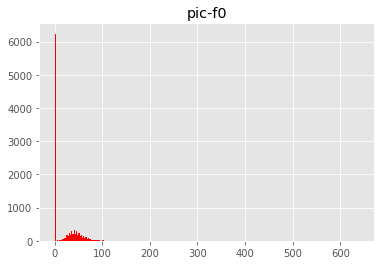

count    10240.000000
mean       446.442383
std        917.213341
min          1.000000
25%         50.000000
50%        108.000000
75%        340.000000
max       8670.000000
Name: f1, dtype: float64

Text(0.5, 1.0, 'pic-f1')

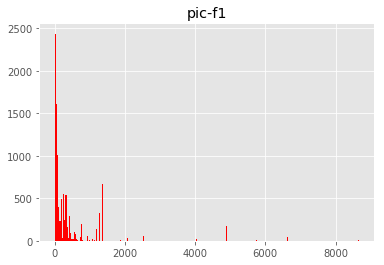

count    10240.000000
mean         1.475586
std          2.214097
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         13.000000
Name: f2, dtype: float64

Text(0.5, 1.0, 'pic-f2')

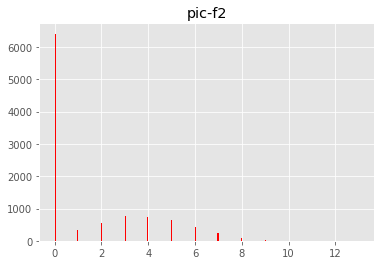

In [8]:
kv_list = [sorted(zip(a,b), key=lambda x:x[0]) for a,b in map(lambda x:x[1:3], template_data)]
df = pd.DataFrame([list(map(lambda x:x[1], kv)) for kv in kv_list], columns=["f0","f1","f2"])
for name in ["f0","f1","f2"]:
    df.groupby(name).size().sort_values(ascending=False).head(4)
for name in ["f0","f1","f2"]:
    df[name].describe()
    n, bins, patches = plt.hist(df[name],bins=256,color='r')
    plt.title("pic-%s" % name)
    plt.show()

- XGB + 相关性系数分析

In [50]:
from scipy import sparse

feat_matrix = sparse.dok_matrix((len(xgb_template_data),189052 + 1))
y = [int(i.split(" ")[0]) for i in xgb_template_data]
for i in range(0,len(xgb_template_data)):
    data = xgb_template_data[i]
    feature_pair = map(lambda x: x.split(":"), data.split(" ")[1:])
    for idx_str, value_str in feature_pair:
        feat_matrix[i,int(idx_str)] = float(value_str)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
gbm.fit(feat_matrix,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
feat_imp = gbm.feature_importances_
a = feat_imp[feat_imp.nonzero()]
b = map(lambda x: feature_map_dict[x]+", "+str(x), feat_imp.nonzero()[0])
feat_imp_sorted = sorted(zip(a,b), key=lambda x: x[0], reverse=True)
feat_imp_sorted[:20]
list(filter(lambda x: "tag" in x[1], feat_imp_sorted))[:5]

In [53]:
xgb_valid = list(itertools.islice(xgb_data_gen,0,1024*10))
valid_feat_matrix = sparse.dok_matrix((len(xgb_valid),189052 + 1))
valid_y = [int(i.split(" ")[0]) for i in xgb_valid]
for i in range(0,len(xgb_template_data)):
    data = xgb_template_data[i]
    feature_pair = map(lambda x: x.split(":"), data.split(" ")[1:])
    for idx_str, value_str in feature_pair:
        feat_matrix[i,int(idx_str)] = float(value_str)
predict_y = gbm.predict(valid_feat_matrix)
from sklearn.metrics import log_loss, roc_auc_score


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ImportError: cannot import name 'logloss'

## TensorFlow 恢复模型，准备获取到Deep侧的输入数据作为XGBoost的特征

 ### 构造 session 和 graph，恢复好计算图

In [4]:
from tensorflow import feature_column
sess = tf.Session()
data = {'pets': ['cat','dot','fish','rabbit']}
column = feature_column.categorical_column_with_identity(key='pets', num_buckets=9)
indicator = feature_column.indicator_column(column)
tensor = feature_column.input_layer(data, [indicator])

sess.run(tensor)

ValueError: Invalid input, not integer. key: pets dtype: <dtype: 'string'>

In [42]:
model_ckpt_path= "/home/zhoutong/py_script/model_dir/DeepFM_fieldMerge_model.ckpt-1332"

inp_meta_path = model_ckpt_path + ".meta"
model_graph = tf.Graph()
with model_graph.as_default():
            model_saver = tf.train.import_meta_graph(inp_meta_path)
# session_config
model_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
model_config.gpu_options.allow_growth = True
# session
model_sess = tf.Session(config=model_config, graph=model_graph)
# 向sessino中载入参数; 注意网络保存时,占位符(tf.placeholder)是不会被保存的
model_saver.restore(model_sess, model_ckpt_path)

INFO:tensorflow:Restoring parameters from /home/zhoutong/py_script/model_dir/DeepFM_fieldMerge_model.ckpt-1332


### debug专用，查看计算图里的变量，展示计算图，以及获取某个变量

In [ ]:
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
# --- 一个可以在notebook里直接显示图的方法
# show_graph(model_graph)
# --- 显示各种tensor，但其实不全
# from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
# print_tensors_in_checkpoint_file(model_ckpt_path, tensor_name=None, all_tensors=False)
# --- 这个方法才是全的
# [n.name for n in model_graph.as_graph_def().node]
model_graph.get_tensor_by_name(r'tower_0/gpu_variables/Deep/input/concat:0')

### 根据数据构造 feed_dict

In [71]:
def gen_feed_dict_from(train_data_partial):
    ###############
    # 原始数据格式化
    ###############
    inp_y, inp_Xi_numeric, inp_Xv_numeric, inp_Xi_category, inp_Xv_category, inp_Xi_multi_hot_app, inp_Xv_multi_hot_app, inp_Xi_multi_hot_tag, inp_Xv_multi_hot_tag = list(map(lambda x: np.array(x), zip(*train_data_partial)))
    tensor_dense_shape = [len(inp_y), 161720 + 1]
    Xi_total = []
    Xv_total = []
    for col_id in range(len(inp_Xi_numeric)):
        Xi_total.append(list(inp_Xi_numeric[col_id]) + list(inp_Xi_category[col_id]) + inp_Xi_multi_hot_app[col_id] + inp_Xi_multi_hot_tag[col_id])
        Xv_total.append(list(inp_Xv_numeric[col_id]) + list(inp_Xv_category[col_id]) + inp_Xv_multi_hot_app[col_id] + inp_Xv_multi_hot_tag[col_id])
    Xi_total = np.array(Xi_total)
    Xv_total = np.array(Xv_total)

    #############################################
    # 构造feed_dict需要的SparseTensor和SparseValue
    #############################################
    # 1. 获取稀疏索引
    def get_sparse_idx(input_df):
        result = []
        for i in range(len(input_df)):
            for j in input_df[i]:
                result.append([i, j])
        return np.array(result)
    # 2. 获取稀疏 SparseTensorValue
    def get_sparse_tensor_from(input_df,inp_tensor_shape):
        tensor_values_ = []
        tensor_indices_ = []
        for i in range(len(input_df)):
            inp = input_df[i]
            tensor_values_.extend(inp)
            tensor_indices_.extend([[i,v] for v in range(len(inp))])
        sp_tensor = tf.SparseTensorValue(indices=tensor_indices_, values=tensor_values_, dense_shape=inp_tensor_shape)
        return sp_tensor
    # 3. generating...        
    v_numeric_sparse = np.reshape(inp_Xv_numeric, -1)
    v_category_sparse = np.reshape(inp_Xv_category, -1)
    idx_numeric_sparse = get_sparse_idx(inp_Xi_numeric)
    idx_category_sparse = get_sparse_idx(inp_Xi_category)
    multi_hot_idx_sp= get_sparse_tensor_from(inp_Xi_multi_hot_app, tensor_dense_shape)
    multi_hot_value_sp = get_sparse_tensor_from(inp_Xv_multi_hot_app, tensor_dense_shape)
    multi_hot_idx_sp_tag= get_sparse_tensor_from(inp_Xi_multi_hot_tag, tensor_dense_shape)
    multi_hot_value_sp_tag = get_sparse_tensor_from(inp_Xv_multi_hot_tag, tensor_dense_shape)
    total_idx_sp = get_sparse_tensor_from(Xi_total,tensor_dense_shape)
    total_value_sp = get_sparse_tensor_from(Xv_total,tensor_dense_shape)

    feed_dict = {
        "dropout_keep_deep:0": [1.0, 1.0, 1.0, 1.0],
        "dropout_keep_fm:0": [1.0, 1.0],
        "tower_0/gpu_variables/feat_total_idx_sp/values:0": total_idx_sp.values,
        "tower_0/gpu_variables/feat_total_idx_sp/indices:0": total_idx_sp.indices,
        "tower_0/gpu_variables/feat_total_value_sp/values:0": total_value_sp.values,
        "tower_0/gpu_variables/feat_total_value_sp/indices:0": total_value_sp.indices,
        "tower_0/gpu_variables/feat_numeric_sp/indices:0": idx_numeric_sparse,
        "tower_0/gpu_variables/feat_numeric_sp/values:0": v_numeric_sparse,
        "tower_0/gpu_variables/feat_numeric_sp/shape:0": tensor_dense_shape,
        "tower_0/gpu_variables/feat_category_sp/indices:0": idx_category_sparse,
        "tower_0/gpu_variables/feat_category_sp/values:0": v_category_sparse,
        "tower_0/gpu_variables/feat_category_sp/shape:0": tensor_dense_shape,
        "tower_0/gpu_variables/feat_multi_hot_idx_sp_app/values:0": multi_hot_idx_sp.values,
        "tower_0/gpu_variables/feat_multi_hot_idx_sp_app/indices:0": multi_hot_idx_sp.indices,
        "tower_0/gpu_variables/feat_multi_hot_value_sp_app/values:0": multi_hot_value_sp.values,
        "tower_0/gpu_variables/feat_multi_hot_value_sp_app/indices:0": multi_hot_value_sp.indices,
        "tower_0/gpu_variables/feat_multi_hot_idx_sp_tag/values:0": multi_hot_idx_sp_tag.values,
        "tower_0/gpu_variables/feat_multi_hot_idx_sp_tag/indices:0": multi_hot_idx_sp_tag.indices,
        "tower_0/gpu_variables/feat_multi_hot_value_sp_tag/values:0": multi_hot_value_sp_tag.values,
        "tower_0/gpu_variables/feat_multi_hot_value_sp_tag/indices:0": multi_hot_value_sp_tag.indices,
        "train_phase:0": False}
    return feed_dict

In [97]:
data_gen = get_generator()
train_data_partial = list(itertools.islice(data_gen,0,1024*90))
# x: 计算图中的 deep_input
feed_dict = gen_feed_dict_from(train_data_partial)
deep_input = model_sess.run(model_graph.get_tensor_by_name(r'tower_0/gpu_variables/Deep/input/concat:0'),feed_dict)
# y: 源数据展开成一维
inp_y = np.array(list(zip(*train_data_partial))[0]).ravel()
inp_y.shape
deep_input.shape

array([0, 1, 1, ..., 0, 0, 0])

array([[ 0.00228253,  0.03825256, -0.07507323, ...,  0.09009009,
         0.        ,  0.        ],
       [-0.05414275, -0.15046448, -0.03879726, ...,  0.001001  ,
         0.        ,  0.        ],
       [-0.04641292, -0.08841577, -0.12176069, ...,  0.25025025,
         0.        ,  0.        ],
       ...,
       [ 0.00228253,  0.03825256, -0.07507323, ...,  0.5405405 ,
         0.3846154 ,  0.00579942],
       [ 0.1560738 ,  0.14484552,  0.03907644, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.1560738 ,  0.14484552,  0.03907644, ...,  0.34034035,
         0.        ,  0.        ]], dtype=float32)

In [98]:
%%time
# max_depth 增加
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
gbm.fit(deep_input,inp_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [107]:
data_gen = get_generator()
# x: 使用计算图中的 deep_input
valid_data = list(itertools.islice(data_gen,1024*90,1024*100))
valid_feed_dict = gen_feed_dict_from(valid_data)
valid_deep_input = model_sess.run(model_graph.get_tensor_by_name(r'tower_0/gpu_variables/Deep/input/concat:0'),valid_feed_dict)
# y: 源数据
valid_inp_y = np.array(list(zip(*valid_data))[0]).ravel()

valid_inp_y.shape
valid_deep_input.shape

(10240,)

(10240, 543)

In [108]:
%%time
y_predict = gbm.predict(valid_deep_input)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 141 ms


/home/zhoutong/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [111]:
y_predict.shape, valid_inp_y.shape
y_predict, valid_inp_y

((10240,), (10240,))

(array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [118]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
log_loss(valid_inp_y,y_predict)

11.333075828280204

In [115]:
y_predict_deepfm = model_sess.run(model_graph.get_tensor_by_name(r'all_pred_reshape_out:0'),valid_feed_dict).ravel()

In [116]:
y_predict_deepfm,y_predict_deepfm.shape

(array([0.27745432, 0.0997011 , 0.07933966, ..., 0.5982073 , 0.5245451 ,
        0.29865313], dtype=float32), (10240,))

In [119]:
log_loss(valid_inp_y,y_predict_deepfm)
roc_auc_score(valid_inp_y,y_predict_deepfm)

0.5837420748721189

0.7269108993894402